# Find out the inside of acc

In [2]:
import time
import os
import pandas as pd
import numpy as np
import torch
import gc
import dgl
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv
from torch.autograd import Variable
from dgl.data import DGLDataset
from sklearn.utils import shuffle
from gcn import GCN
from my_dataset import MyDataset

Using backend: pytorch


In [3]:
dfTest = pd.read_csv('./test_simple.csv')
testFiles = dfTest['file_name']
testFiles[-10:-5]

2630    ../negative_graph_featureSimplified/4b6r_ligand_5
2631    ../negative_graph_featureSimplified/1os5_ligand_3
2632    ../negative_graph_featureSimplified/4dy6_ligand_7
2633    ../negative_graph_featureSimplified/1alw_ligand_2
2634    ../negative_graph_featureSimplified/1mq6_ligand_1
Name: file_name, dtype: object

In [4]:
testFiles[:5]

0    ../positive_graph_featureSimplified/1v2s
1    ../positive_graph_featureSimplified/4lxz
2    ../positive_graph_featureSimplified/4tmk
3    ../positive_graph_featureSimplified/5efh
4    ../positive_graph_featureSimplified/3ps1
Name: file_name, dtype: object

In [5]:
modelPath = '../models/gcnGAT_with_simple_feature1642648899.pkl'
model = torch.load(modelPath)
model

GCN(
  (gnn_layerList): ModuleList(
    (0): GATConv(
      (fc): Linear(in_features=34, out_features=80, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (1): GATConv(
      (fc): Linear(in_features=80, out_features=160, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (2): GATConv(
      (fc): Linear(in_features=160, out_features=112, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (3): GATConv(
      (fc): Linear(in_features=112, out_features=160, bias=False)
      (feat_drop): Dropout(p=0.0, inplace=False)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (leaky_relu): LeakyReLU(negative_slope=0.2)
    )
    (4): GATCon

In [7]:
device = torch.device("cuda:0")
testPreds = []
for i, file in enumerate(testFiles):
    g = dgl.load_graphs(file)[0][0].to(device) # load_graphs returns tuple(graphs, labels)
    pred = model(g, g.ndata['h'].float()).squeeze(1).squeeze(1)
    testPreds.append(pred.round().item())
    print('\r' + str(i), end='')

2639

In [8]:
len(testFiles) == len(testPreds)

True

In [9]:
dfPred = pd.DataFrame(columns=['file_name', 'label'])
dfPred['file_name'] = testFiles
dfPred['label'] = testPreds
dfPred.head()

,file_name,label
0,../positive_graph_featureSimplified/1v2s,0.0
1,../positive_graph_featureSimplified/4lxz,1.0
2,../positive_graph_featureSimplified/4tmk,1.0
3,../positive_graph_featureSimplified/5efh,0.0
4,../positive_graph_featureSimplified/3ps1,1.0


In [10]:
def getNegativeName(file_name):
    if 'negative' not in file_name:
        return ''
    start = file_name.find('ligand')-5
    end = file_name.find('ligand')+8
    return file_name[start:end]

In [11]:
getNegativeName('../negative_graph_save8A_test/6ny0_ligand_7.p')

'6ny0_ligand_7'

In [12]:
'./positive_graph_save/6f20'[-4:]

'6f20'

In [13]:
dfPred.to_csv('./test_preds.csv')

In [14]:
dfFalse = pd.DataFrame(columns=['file_name', 'label']) # comment: FP or FT
for i, row in dfPred.iterrows():
    # print(row)
    fname = row['file_name']
    #print(fname)
    pred = row['label']
    if ('negative' in fname and pred == 1.0) or ('positive' in fname and pred == 0.0):
        fname = fname[-4:] if 'positive' in fname else getNegativeName(fname)
        dfFalse = dfFalse.append([{'file_name': fname, 'label': pred}], ignore_index=True)
        
len(dfFalse)

469

In [15]:
dfFalse.to_csv('pred_false.csv')

# Analyze acc  
----------------------------------------------------
**pred_false.csv**: false pred of test data  
**test_preds.csv**: pred of test data  

In [16]:
import pandas as pd
import numpy as np
import os
from data_filter import DataFilter
from calculate_rmsd import RMSDCalculator

In [17]:
rmsdCal = RMSDCalculator()
datafilter = DataFilter()

In [25]:
predFalseDf = pd.read_csv('./pred_false.csv')
predFalseDf.tail()

,Unnamed: 0,file_name,label
464,464,2o0u_ligand_2,1.0
465,465,6gfs_ligand_1,1.0
466,466,4b6r_ligand_5,1.0
467,467,1alw_ligand_2,1.0
468,468,2zdm_ligand_5,1.0


In [19]:
testPredsDf = pd.read_csv('./test_preds.csv')
testPredsDf.head()

,Unnamed: 0,file_name,label
0,0,../positive_graph_featureSimplified/1v2s,0.0
1,1,../positive_graph_featureSimplified/4lxz,1.0
2,2,../positive_graph_featureSimplified/4tmk,1.0
3,3,../positive_graph_featureSimplified/5efh,0.0
4,4,../positive_graph_featureSimplified/3ps1,1.0


In [28]:
fns = []
fnRmsds = []
for i, row in predFalseDf.iterrows():
    if 'ligand' in row['file_name']:
        fns.append(row['file_name'])
        
        dataId = datafilter.getDataID(row['file_name'])
        posFileName = datafilter.getFilePathByDataID(dataId[:4])
        negFileName = datafilter.getFilePathByDataID(dataId)
        rmsd = rmsdCal.calculateRMSD(posFileName, negFileName)
        '''
        Analyze FPs in [7.5, 8.0]
        '''
        if rmsd > 7.5 and rmsd < 8.0:
            print(row['file_name'])
        fnRmsds.append(rmsd)
print(len(fns), len(fnRmsds))

1kc7_ligand_3
1ghy_ligand_4
3tzm_ligand_2
5igm_ligand_8
4wov_ligand_5
2pwc_ligand_9
4ca5_ligand_9
297 297


## draw figs

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [22]:
fnRmsds2To10 = []
for i in fnRmsds:
    if i >2.0 and i < 10.0:
        fnRmsds2To10.append(i)

/home/kmk_gmx/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


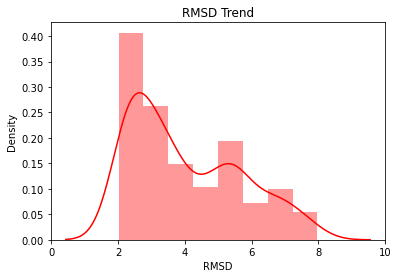

In [23]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("RMSD Trend")
rmsdContFigs = sns.distplot(fnRmsds2To10, axlabel='RMSD', color="red", ax=ax)

In [24]:
rmsdContFigs.get_figure().savefig('../figs/analyze_acc_trend_34gat.png', dpi=400)

In [27]:
for i, rmsd in enumerate(fnRmsds2To10):
    if rmsd >= 7.5 and rmsd <= 8:
        print(predFalseDf.iloc[i])

Unnamed: 0       3
file_name     5mjn
label            0
Name: 3, dtype: object
Unnamed: 0      13
file_name     5u11
label            0
Name: 13, dtype: object
Unnamed: 0      74
file_name     3lzu
label            0
Name: 74, dtype: object
Unnamed: 0              172
file_name     4lxz_ligand_2
label                     1
Name: 172, dtype: object
Unnamed: 0              178
file_name     5ioz_ligand_5
label                     1
Name: 178, dtype: object
Unnamed: 0              206
file_name     4w9p_ligand_4
label                     1
Name: 206, dtype: object
Unnamed: 0              291
file_name     6gf9_ligand_7
label                     1
Name: 291, dtype: object
